In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras import Sequential
from keras.layers import Dense  
from sklearn.model_selection import StratifiedKFold
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score

In [142]:
df = pd.read_feather("train_data.ftr")

In [157]:
df.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,...,NaN,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960449,0.002455,0.013687,1.002930,0.001372,0.117188,0.000685,0.005531,...,NaN,NaN,0.006119,0.004517,0.003201,NaN,0.008423,0.006527,0.009598,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947266,0.002483,0.015190,1.000977,0.007607,0.117310,0.004654,0.009308,...,NaN,NaN,0.003672,0.004944,0.008888,NaN,0.001670,0.008125,0.009827,0


# Data exploration

In [143]:
df.info(max_cols=20000, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Data columns (total 191 columns):
 #    Column       Non-Null Count    Dtype         
---   ------       --------------    -----         
 0    customer_ID  5531451 non-null  object        
 1    S_2          5531451 non-null  datetime64[ns]
 2    P_2          5485466 non-null  float16       
 3    D_39         5531451 non-null  float16       
 4    B_1          5531451 non-null  float16       
 5    B_2          5529435 non-null  float16       
 6    R_1          5531451 non-null  float16       
 7    S_3          4510907 non-null  float16       
 8    D_41         5529435 non-null  float16       
 9    B_3          5529435 non-null  float16       
 10   D_42         791314 non-null   float16       
 11   D_43         3873055 non-null  float16       
 12   D_44         5257132 non-null  float16       
 13   B_4          5531451 non-null  float16       
 14   D_45         5529434 non-null  float16       
 1

### NaN exploration

In [144]:
cols = sorted(df.columns[2:].tolist())
nan = df[cols].isna().sum(axis=0).reset_index(name='NaN_count')
nan["NaN_groups"] = nan.loc[nan["NaN_count"]>0].groupby('NaN_count').transform('count')
nan = nan.dropna()
nan["NaN_groups"].unique()

array([ 1.,  2., 13., 11.,  5.,  3.])

In [145]:
nan["NaN_groups"]

4       1.0
6       2.0
7      13.0
8       1.0
10     13.0
       ... 
180     1.0
181     1.0
182     2.0
185     2.0
187     1.0
Name: NaN_groups, Length: 121, dtype: float64

Seems like NaN groups > 5 is a sigificant number.

This means there are 11, 13, and 14 variables with the same number of NaNs. Look into why.

In [146]:
nan.loc[nan["NaN_groups"]>5].sort_values(['NaN_count','index'])

,index,NaN_count,NaN_groups
7,B_16,2016,13.0
10,B_19,2016,13.0
11,B_2,2016,13.0
12,B_20,2016,13.0
14,B_22,2016,13.0
18,B_26,2016,13.0
19,B_27,2016,13.0
22,B_3,2016,13.0
23,B_30,2016,13.0
26,B_33,2016,13.0


In [147]:
nan_groups = nan.loc[nan["NaN_groups"]>5]["NaN_count"].unique()
nan_cols = list()
for i in nan_groups:
    nan_cols.append(nan.loc[nan["NaN_count"]==i]["index"].values.tolist())

In [149]:
cluster0_customers = set(df.loc[pd.isnull(df[nan_cols[0][0]]),'customer_ID'])
cluster1_customers = set(df.loc[pd.isnull(df[nan_cols[1][0]]),'customer_ID'])
cluster2_customers = set(df.loc[pd.isnull(df[nan_cols[2][0]]),'customer_ID'])

In [150]:
df.loc[df.customer_ID.isin(cluster0_customers),['customer_ID','S_2']+nan_cols[0]][:10]

,customer_ID,S_2,B_16,B_19,B_2,B_20,B_22,B_26,B_27,B_3,B_30,B_33,B_38,D_41,D_54
12883,009b4f146ac20c9e528e23137b3fbef84856f327124ade...,2017-11-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12884,009b4f146ac20c9e528e23137b3fbef84856f327124ade...,2017-12-31,0.008171,0.007866,0.818848,0.002268,0.004444,0.001448,0.008553,0.000271,0.0,1.006836,1.0,0.008209,1.006836
12885,009b4f146ac20c9e528e23137b3fbef84856f327124ade...,2018-01-05,0.087402,0.000281,0.074036,0.064575,0.001340,0.003338,0.007771,0.033600,0.0,0.006824,4.0,0.005024,1.009766
12886,009b4f146ac20c9e528e23137b3fbef84856f327124ade...,2018-02-15,0.173584,0.505859,0.000795,0.120544,0.508789,0.009933,0.002901,0.201660,2.0,0.007778,4.0,0.006496,1.006836
12887,009b4f146ac20c9e528e23137b3fbef84856f327124ade...,2018-03-03,0.255127,0.666992,0.014709,0.184692,0.504395,0.005295,0.007221,0.281006,1.0,0.004322,4.0,0.009712,1.003906
15183,00b686ade48123a567b066546d791c825ddd735b1bbd9c...,2017-03-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15184,00b686ade48123a567b066546d791c825ddd735b1bbd9c...,2017-04-29,0.004581,0.000033,0.812988,0.001889,0.001067,0.001270,0.007633,0.009499,0.0,1.003906,1.0,0.002886,1.005859
15185,00b686ade48123a567b066546d791c825ddd735b1bbd9c...,2017-05-08,0.086121,0.001251,0.099976,0.061615,0.001476,0.001970,0.008842,0.026138,0.0,0.005058,4.0,0.008438,1.000977
15186,00b686ade48123a567b066546d791c825ddd735b1bbd9c...,2017-06-07,0.174805,0.002474,0.108887,0.122803,0.006821,0.008232,0.008514,0.035706,0.0,0.003805,4.0,0.002865,1.001953
15187,00b686ade48123a567b066546d791c825ddd735b1bbd9c...,2017-07-08,0.255859,0.006241,0.097351,0.185425,0.007366,0.008812,0.009888,0.044556,0.0,0.009888,4.0,0.003548,1.008789


In [151]:
df.loc[df.customer_ID.isin(cluster1_customers),['customer_ID','S_2']+nan_cols[1]][:10]

,customer_ID,S_2,D_103,D_104,D_107,D_128,D_129,D_130,D_131,D_139,D_141,D_143,D_145
133,00013c6e1cec7c21bede7cb319f1e28eb994f5625257f4...,2017-03-25,1.006836,0.955566,0.341309,1.006836,1.007812,0.007133,0.007664,0.009720,0.005550,0.004009,0.002956
134,00013c6e1cec7c21bede7cb319f1e28eb994f5625257f4...,2017-04-14,1.006836,0.961426,0.334717,1.003906,1.002930,0.004627,0.009285,0.007339,0.002329,0.001006,0.007664
135,00013c6e1cec7c21bede7cb319f1e28eb994f5625257f4...,2017-05-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
136,00013c6e1cec7c21bede7cb319f1e28eb994f5625257f4...,2017-06-12,1.004883,0.965332,0.342773,1.000977,1.001953,0.005569,0.005753,0.007751,0.000915,0.007919,0.000578
137,00013c6e1cec7c21bede7cb319f1e28eb994f5625257f4...,2017-07-01,1.007812,0.963867,0.335693,1.005859,1.005859,0.001252,0.007713,0.001164,0.004852,0.006252,0.005459
138,00013c6e1cec7c21bede7cb319f1e28eb994f5625257f4...,2017-08-18,1.006836,0.963867,0.336426,1.000977,1.002930,0.005043,0.004307,0.007305,0.003342,0.004837,0.006893
139,00013c6e1cec7c21bede7cb319f1e28eb994f5625257f4...,2017-09-09,1.007812,0.961914,0.334961,1.000000,1.005859,0.004173,0.002312,0.002691,0.008507,0.006626,0.009346
140,00013c6e1cec7c21bede7cb319f1e28eb994f5625257f4...,2017-10-02,1.000977,0.966797,0.341309,1.002930,1.001953,0.001366,0.008224,0.009079,0.007950,0.005875,0.000613
141,00013c6e1cec7c21bede7cb319f1e28eb994f5625257f4...,2017-11-13,1.005859,0.965332,0.341553,0.999512,1.007812,0.003160,0.000647,0.006031,0.006187,0.004883,0.003609
142,00013c6e1cec7c21bede7cb319f1e28eb994f5625257f4...,2017-12-21,1.009766,0.966797,0.341797,1.003906,1.009766,0.004196,0.008522,0.006283,0.005028,0.005306,0.009628


In [152]:
df.loc[df.customer_ID.isin(cluster2_customers),['customer_ID','S_2']+nan_cols[1]][15:25]

,customer_ID,S_2,D_103,D_104,D_107,D_128,D_129,D_130,D_131,D_139,D_141,D_143,D_145
132,0001337ded4e1c2539d1a78ff44a457bd4a95caa55ba17...,2018-03-12,1.008789,0.968750,0.337402,0.009041,0.000879,1.001953,1.006836,1.004883,0.876465,1.005859,0.094788
250,000391f219520dbca6c3c1c46e0fab569da163f79ee266...,2017-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
251,000391f219520dbca6c3c1c46e0fab569da163f79ee266...,2018-01-01,1.005859,0.976074,0.336182,0.007526,0.000042,0.006729,0.001464,0.005703,0.004227,0.006462,0.009605
252,000391f219520dbca6c3c1c46e0fab569da163f79ee266...,2018-02-04,1.000977,0.983398,0.335449,0.006443,0.009644,0.000320,0.001143,0.006569,0.002407,0.003729,0.000420
253,000391f219520dbca6c3c1c46e0fab569da163f79ee266...,2018-03-16,1.009766,0.979980,0.339600,0.006638,0.001049,0.007439,0.004520,0.004181,0.004124,0.004738,0.000415
332,0004860c260168fcaad0734a1dfedb7ceb1a83aaac54e2...,2017-07-28,1.003906,0.958496,0.669434,0.005257,0.009758,0.006817,0.001310,1.001953,0.864746,1.003906,1.093750
333,0004860c260168fcaad0734a1dfedb7ceb1a83aaac54e2...,2017-08-08,1.008789,0.964355,0.674805,0.006771,0.007774,0.003412,0.003464,1.007812,0.870117,1.006836,1.096680
334,0004860c260168fcaad0734a1dfedb7ceb1a83aaac54e2...,2017-09-04,1.000000,0.954102,0.671875,0.003084,0.001477,0.003828,0.007595,1.006836,0.867188,1.006836,1.098633
335,0004860c260168fcaad0734a1dfedb7ceb1a83aaac54e2...,2017-10-27,1.004883,0.948730,0.669922,0.003660,0.000122,0.000005,0.007904,1.003906,0.869629,1.001953,1.096680
336,0004860c260168fcaad0734a1dfedb7ceb1a83aaac54e2...,2017-11-05,1.005859,0.952148,0.670410,0.007488,0.008568,0.002993,0.003178,1.000977,0.869629,1.002930,1.092773


Looks like for variables with many NaNs, entire rows are empty. Could mean new accounts, so NaN values might have meaning. Instead of imputing the mean, let's put in 0.

### Variable exploration

In [153]:
var_freq = list()
for col in df.columns:
    var_freq.append(str.split(col, "_")[0])

variables = set(var_freq[1:-1])

var_count = list()
for v in variables:
    var_count.append(var_freq.count(v))

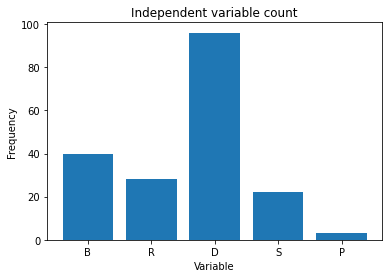

In [154]:
plt.bar(list(variables), var_count)
plt.xlabel("Variable")
plt.ylabel("Frequency")
plt.title("Independent variable count")
plt.show()

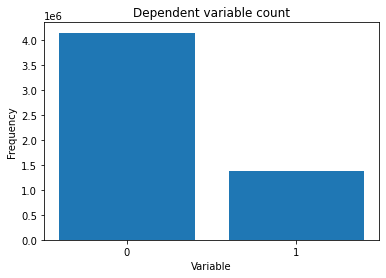

In [155]:
plt.bar(df.loc[:,"target"].unique(), df.loc[:,"target"].value_counts())
plt.title("Train data output")
plt.xlabel("Variable")
plt.ylabel("Frequency")
plt.title("Dependent variable count")
plt.xticks([0,1])
plt.show()

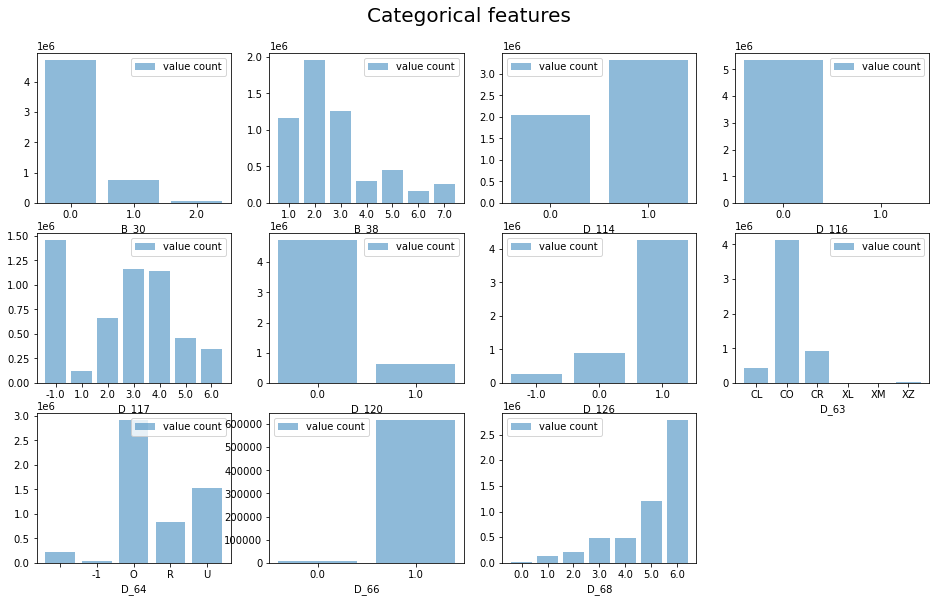

In [156]:
cat_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
plt.figure(figsize=(16, 16))
for i, f in enumerate(cat_features):
    plt.subplot(5, 4, i+1)
    temp = pd.DataFrame(df[f].value_counts().sort_index().rename('count'))
    temp.index.name = 'value'
    temp.reset_index(inplace=True)
    plt.bar(temp.index, temp['count'], alpha=0.5, label='value count')

    plt.xlabel(f)
    plt.legend()
    plt.xticks(temp.index, temp.value)
plt.suptitle('Categorical features', fontsize=20, y=.92)
plt.show()
del temp

In [90]:
# Create dummy variables and train/test set

cat_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120',
                'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
for cat_col in cat_cols:
    dummy = pd.get_dummies(df[cat_col], prefix=[cat_col])
    df = df.drop([cat_col], axis=1)
    df = pd.concat([df, dummy], axis=1)
del dummy
    
df = df.drop(["S_2"], axis=1)
df = df.groupby("customer_ID").mean()
y = df['target']
X = df.loc[:, df.columns != "target"]
X = X.fillna(0.0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### MDI Feature Importance

In [14]:
rfc = RandomForestClassifier(random_state=0, n_estimators=10)
rfc.fit(X_train,y_train)

RandomForestClassifier(n_estimators=10, random_state=0)

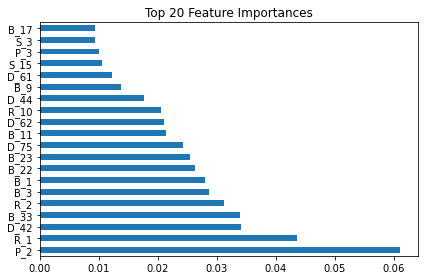

In [15]:
feature_imp = pd.DataFrame()
feature_imp['features'] = X_train.columns
feature_imp['importance'] = rfc.feature_importances_
feature_imp = feature_imp.sort_values('importance', ascending=False)

mdi_importances = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=False)
ax = mdi_importances[:20].plot.barh()
ax.set_title("Top 20 Feature Importances")
ax.figure.tight_layout()
plt.show()

### Permutation Feature Importance

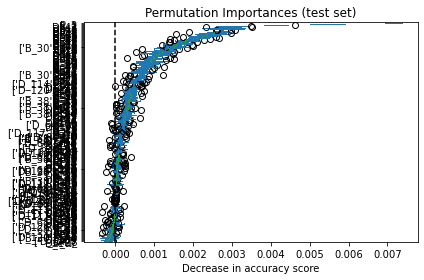

In [17]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rfc, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)


ax = importances.plot.box(vert=False, whis=1)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

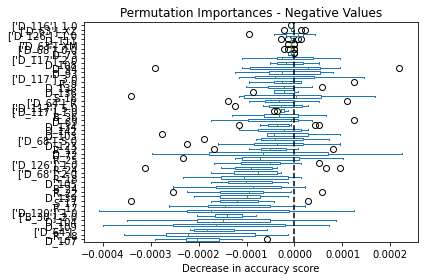

In [53]:
neg_importance = importances.mean()[importances.mean()<0].index.tolist()
ax = importances.loc[:,neg_importance].plot.box(vert=False, whis=1)
ax.set_title("Permutation Importances - Negative Values")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [36]:
print("Accuracy for random forest classification: ")
print("Train data accuracy:",rfc.score(X_train, y_train))
print("Test data accuracy:",rfc.score(X_test, y_test))

Accuracy for random forest classification: 
Train data accuracy: 0.9930425633251255
Test data accuracy: 0.8695323735781629


In [91]:
df_test = df.drop(neg_importance, axis=1)

y = df_test['target']
X = df_test.loc[:, df_test.columns != "target"]
X = X.fillna(0.0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [39]:
rfc = RandomForestClassifier(random_state=0, n_estimators=10)
rfc.fit(X_train,y_train)

RandomForestClassifier(n_estimators=10, random_state=0)

In [40]:
print("Accuracy for random forest classification: ")
print("Train data accuracy:",rfc.score(X_train, y_train))
print("Test data accuracy:",rfc.score(X_test, y_test))

Accuracy for random forest classification: 
Train data accuracy: 0.9931203870015782
Test data accuracy: 0.8702732542092189


In [58]:
top_10_importance = importances.mean().sort_values()[-10:].index.tolist()

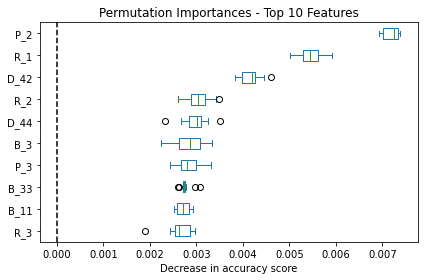

In [61]:
top_10_importance = importances.mean().sort_values()[-10:].index.tolist()
ax = importances.loc[:,top_10_importance].plot.box(vert=False, whis=1)
ax.set_title("Permutation Importances - Top 10 Features")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [ ]:
del df_test

In [92]:
df = df.drop(neg_importance, axis=1)

y = df['target']
X = df.loc[:, df.columns != "target"]
X = X.fillna(0.0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [68]:
y = df['target']
X = df.loc[:, df.columns != "target"]
X = X.fillna(0.0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [73]:
X

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,['D_63']_XL,['D_64']_-1,['D_64']_O,['D_64']_U,['D_66']_0.0,['D_66']_1.0,['D_68']_1.0,['D_68']_3.0,['D_68']_4.0,['D_68']_6.0
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.933594,0.010704,0.012009,1.004883,0.004509,0.113220,0.005020,0.006454,0.0,0.000000,...,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.899902,0.215210,0.025650,0.991211,0.006245,0.120605,0.004993,0.005665,0.0,0.144531,...,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.878418,0.004181,0.004387,0.815430,0.006622,0.000000,0.006844,0.005493,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.599121,0.048859,0.059875,0.955078,0.005665,0.247803,0.005489,0.006424,0.0,0.061035,...,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.692308,0.000000,0.153846
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.891602,0.004642,0.005939,0.814453,0.004181,0.173096,0.005352,0.005089,0.0,0.048767,...,0.0,0.0,1.000000,0.000000,0.0,1.0,0.0,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,0.848633,0.119202,0.029175,1.004883,0.005459,0.125977,0.003922,0.005814,0.0,0.152588,...,0.0,0.0,0.000000,1.000000,0.0,1.0,0.0,0.000000,0.000000,1.000000
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,0.859375,0.066406,0.368408,0.042358,0.005543,0.273682,0.005306,0.271973,0.0,0.327637,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,0.786621,0.221558,0.043030,0.854492,0.004753,0.084351,0.182739,0.057556,0.0,0.121216,...,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000


# Modeling

### Random Forest Classifier

In [69]:
rfc = RandomForestClassifier(random_state=0, n_estimators=10, min_samples_leaf=20)
rfc.fit(X_train,y_train)

RandomForestClassifier(min_samples_leaf=20, n_estimators=10, random_state=0)

In [71]:
print("Accuracy for random forest classification: ")
print("Train data accuracy:",rfc.score(X_train, y_train))
print("Test data accuracy:",rfc.score(X_test, y_test))

Accuracy for random forest classification: 
Train data accuracy: 0.9164547268544604
Test data accuracy: 0.8799918648401296


### Neural Network

In [7]:
train_acc_list = list()
test_acc_list = list()
batches = [5, 10, 15, 25, 50, 75, 100, 150]
for i in batches:
    
    classifier = Sequential()
    #Hidden Layer
    classifier.add(Dense(20, activation='relu', kernel_initializer='random_normal', input_dim=len(X_train.columns)))
    classifier.add(Dense(10, activation='relu', kernel_initializer='random_normal'))
    classifier.add(Dense(10, activation='relu', kernel_initializer='random_normal'))
    #Output Layer
    classifier.add(Dense(1, activation='sigmoid'))
    classifier.compile(optimizer ='adam',loss='mean_squared_error', metrics =['accuracy'])
    
    classifier.fit(X_train,y_train, batch_size=i, epochs=1)
    train_acc_list.append(classifier.evaluate(X_train, y_train, verbose=0)[1])
    test_acc_list.append(classifier.evaluate(X_test, y_test, verbose=0)[1])

2142/2142 [==============================] - 4s 1ms/step - loss: 0.0857 - accuracy: 0.8795


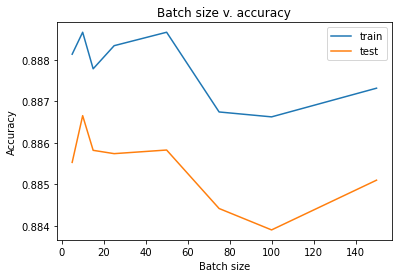

In [8]:
plt.plot(batches,train_acc_list,label="train")
plt.plot(batches,test_acc_list,label="test")
plt.legend()
plt.title("Batch size v. accuracy")
plt.xlabel("Batch size")
plt.ylabel("Accuracy")
plt.show()

In [9]:
train_acc_list = list()
test_acc_list = list()
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for i in epochs:
    classifier = Sequential()
    #Hidden Layer
    classifier.add(Dense(20, activation='relu', kernel_initializer='random_normal', input_dim=len(X_train.columns)))
    classifier.add(Dense(10, activation='relu', kernel_initializer='random_normal'))
    classifier.add(Dense(10, activation='relu', kernel_initializer='random_normal'))
    #Output Layer
    classifier.add(Dense(1, activation='sigmoid'))
    classifier.compile(optimizer ='adam',loss='mean_squared_error', metrics =['accuracy'])
    classifier.fit(X_train,y_train, batch_size=50, epochs=i)
    train_acc_list.append(classifier.evaluate(X_train, y_train, verbose=0)[1])
    test_acc_list.append(classifier.evaluate(X_test, y_test, verbose=0)[1])

6425/6425 [==============================] - 6s 826us/step - loss: 0.0825 - accuracy: 0.8825
Epoch 1/2
6425/6425 [==============================] - 6s 806us/step - loss: 0.0824 - accuracy: 0.8831
Epoch 2/2
6425/6425 [==============================] - 5s 804us/step - loss: 0.0784 - accuracy: 0.8885
Epoch 1/3
6425/6425 [==============================] - 6s 793us/step - loss: 0.0828 - accuracy: 0.8826
Epoch 2/3
6425/6425 [==============================] - 5s 799us/step - loss: 0.0788 - accuracy: 0.8879
Epoch 3/3
6425/6425 [==============================] - 5s 805us/step - loss: 0.0778 - accuracy: 0.8895
Epoch 1/4
6425/6425 [==============================] - 6s 823us/step - loss: 0.0823 - accuracy: 0.8830
Epoch 2/4
6425/6425 [==============================] - 5s 797us/step - loss: 0.0784 - accuracy: 0.8883
Epoch 3/4
6425/6425 [==============================] - 5s 788us/step - loss: 0.0774 - accuracy: 0.8898
Epoch 4/4
6425/6425 [==============================] - 5s 779us/step - loss: 0.0768

In [11]:
epochs2 = [11, 12, 13, 14, 15]
for i in epochs2:
    classifier = Sequential()
    #Hidden Layer
    classifier.add(Dense(20, activation='relu', kernel_initializer='random_normal', input_dim=len(X_train.columns)))
    classifier.add(Dense(10, activation='relu', kernel_initializer='random_normal'))
    classifier.add(Dense(10, activation='relu', kernel_initializer='random_normal'))
    #Output Layer
    classifier.add(Dense(1, activation='sigmoid'))
    classifier.compile(optimizer ='adam',loss='mean_squared_error', metrics =['accuracy'])
    classifier.fit(X_train,y_train, batch_size=50, epochs=i)
    train_acc_list.append(classifier.evaluate(X_train, y_train, verbose=0)[1])
    test_acc_list.append(classifier.evaluate(X_test, y_test, verbose=0)[1])

Epoch 1/11
6425/6425 [==============================] - 6s 837us/step - loss: 0.0826 - accuracy: 0.8828
Epoch 2/11
6425/6425 [==============================] - 5s 849us/step - loss: 0.0782 - accuracy: 0.8889
Epoch 3/11
6425/6425 [==============================] - 6s 863us/step - loss: 0.0772 - accuracy: 0.8905
Epoch 4/11
6425/6425 [==============================] - 5s 855us/step - loss: 0.0766 - accuracy: 0.8912
Epoch 5/11
6425/6425 [==============================] - 5s 840us/step - loss: 0.0761 - accuracy: 0.8918
Epoch 6/11
6425/6425 [==============================] - 5s 839us/step - loss: 0.0757 - accuracy: 0.8928
Epoch 7/11
6425/6425 [==============================] - 6s 860us/step - loss: 0.0753 - accuracy: 0.8930
Epoch 8/11
6425/6425 [==============================] - 5s 839us/step - loss: 0.0750 - accuracy: 0.8937
Epoch 9/11
6425/6425 [==============================] - 5s 848us/step - loss: 0.0747 - accuracy: 0.8940
Epoch 10/11
6425/6425 [==============================] - 5s 849u

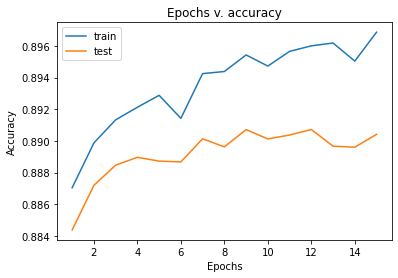

In [13]:
plt.plot(epochs+epochs2,train_acc_list,label="train")
plt.plot(epochs+epochs2,test_acc_list,label="test")
plt.legend()
plt.title("Epochs v. accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
pred = classifier.predict(X_test)
predictions = (pred > 0.5)*1
predictions.T[0]

plt.bar(unique, counts)
counts

In [ ]:
plt.bar(unique, counts)
counts

In [74]:
classifier = Sequential()
#Hidden Layer
classifier.add(Dense(20, activation='relu', kernel_initializer='random_normal', input_dim=len(X_train.columns)))
classifier.add(Dense(10, activation='relu', kernel_initializer='random_normal'))
classifier.add(Dense(10, activation='relu', kernel_initializer='random_normal'))
#Output Layer
classifier.add(Dense(1, activation='sigmoid'))
classifier.compile(optimizer ='adam',loss='mean_squared_error', metrics =['accuracy'])

classifier.fit(X_train,y_train, batch_size=20, epochs=10)

train_acc = classifier.evaluate(X_train, y_train, verbose=0)
print('Train loss:', train_acc[0]) 
print('Train accuracy:', train_acc[1])
test_acc = classifier.evaluate(X_test, y_test, verbose=0)
print('Test loss:', test_acc[0]) 
print('Test accuracy:', test_acc[1])

Epoch 1/10
16062/16062 [==============================] - 13s 807us/step - loss: 0.0815 - accuracy: 0.8838
Epoch 2/10
16062/16062 [==============================] - 13s 802us/step - loss: 0.0784 - accuracy: 0.8881
Epoch 3/10
16062/16062 [==============================] - 13s 809us/step - loss: 0.0773 - accuracy: 0.8901
Epoch 4/10
16062/16062 [==============================] - 13s 806us/step - loss: 0.0766 - accuracy: 0.8909
Epoch 5/10
16062/16062 [==============================] - 13s 815us/step - loss: 0.0762 - accuracy: 0.8913
Epoch 6/10
16062/16062 [==============================] - 14s 841us/step - loss: 0.0759 - accuracy: 0.8922
Epoch 7/10
16062/16062 [==============================] - 13s 834us/step - loss: 0.0755 - accuracy: 0.8930
Epoch 8/10
16062/16062 [==============================] - 13s 835us/step - loss: 0.0752 - accuracy: 0.8935
Epoch 9/10
16062/16062 [==============================] - 13s 832us/step - loss: 0.0750 - accuracy: 0.8937
Epoch 10/10
16062/16062 [============

# K-means Clustering

In [75]:
from sklearn.cluster import KMeans

In [76]:
wcss = [] 
for number_of_clusters in range(1, 11): 
    kmeans = KMeans(n_clusters = number_of_clusters, random_state = 42)
    kmeans.fit(X.loc[:,mdi_importances[0:11].index]) 
    wcss.append(kmeans.inertia_)
    print("Done:",number_of_clusters)
wcss

Done: 1
Done: 2
Done: 3
Done: 4
Done: 5
Done: 6
Done: 7
Done: 8
Done: 9
Done: 10


[250119.56518025484,
 124581.12797375338,
 98086.4739932568,
 87959.08868362523,
 79086.97043276473,
 72599.87262630435,
 68785.72225799556,
 65309.91195867772,
 62520.03344824671,
 59756.73123671902]

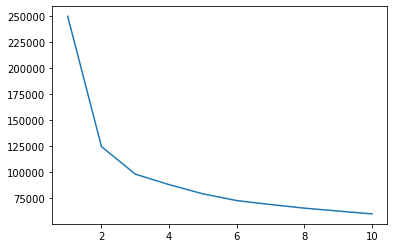

In [77]:
ks = [1, 2, 3, 4, 5 , 6 , 7 , 8, 9, 10]
plt.plot(ks, wcss)

In [78]:
kmeans = KMeans(n_clusters = 2, random_state = 42)
kmeans.fit(X.loc[:,mdi_importances[0:11].index])
clusters, clusters_count = np.unique(kmeans.labels_, return_counts=True)

<BarContainer object of 2 artists>

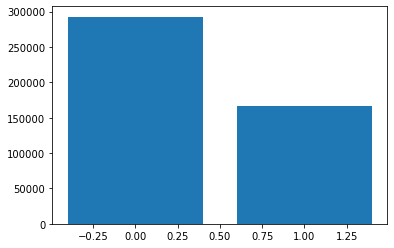

In [79]:
plt.bar(clusters, clusters_count)

In [80]:
df["cluster"] = kmeans.labels_

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [82]:
df0 = df.loc[df["cluster"]==0]
y0 = df0['target']
X0 = df0.loc[:, df.columns != "target"]
X0 = X0.fillna(0.0)
X_train0, X_test0, y_train0, y_test0 = train_test_split(X0, y0, test_size=0.3, random_state=0)

classifier = Sequential()
#Hidden Layer
classifier.add(Dense(20, activation='relu', kernel_initializer='random_normal', input_dim=len(X_train0.columns)))
classifier.add(Dense(10, activation='relu', kernel_initializer='random_normal'))
classifier.add(Dense(10, activation='relu', kernel_initializer='random_normal'))
#Output Layer
classifier.add(Dense(1, activation='sigmoid'))
classifier.compile(optimizer ='adam',loss='mean_squared_error', metrics =['accuracy'])

classifier.fit(X_train0,y_train0, batch_size=20, epochs=1)

print("Cluster 0 results:")

train_acc = classifier.evaluate(X_train0, y_train0, verbose=0)
print('Test loss:', train_acc[0]) 
print('Test accuracy:', train_acc[1])

test_acc = classifier.evaluate(X_test0, y_test0, verbose=0)
print('Test loss:', test_acc[0]) 
print('Test accuracy:', test_acc[1])

10247/10247 [==============================] - 9s 824us/step - loss: 0.0454 - accuracy: 0.9389
Cluster 0 results:
Test loss: 0.04207511246204376
Test accuracy: 0.9418495893478394
Test loss: 0.04274408519268036
Test accuracy: 0.9411363005638123


In [84]:
df1 = df.loc[df["cluster"]==1]
y1 = df1['target']
X1 = df1.loc[:, df.columns != "target"]
X1 = X1.fillna(0.0)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, random_state=5)

classifier = Sequential()
#Hidden Layer
classifier.add(Dense(20, activation='relu', kernel_initializer='random_normal', input_dim=len(X_train1.columns)))
classifier.add(Dense(10, activation='relu', kernel_initializer='random_normal'))
classifier.add(Dense(10, activation='relu', kernel_initializer='random_normal'))
#Output Layer
classifier.add(Dense(1, activation='sigmoid'))
classifier.compile(optimizer ='adam',loss='mean_squared_error', metrics =['accuracy'])

classifier.fit(X_train1,y_train1, batch_size=20, epochs=1)

print("Cluster 1 results:")

train_acc = classifier.evaluate(X_train1, y_train1, verbose=0)
print('Test loss:', train_acc[0]) 
print('Test accuracy:', train_acc[1])

test_acc = classifier.evaluate(X_test1, y_test1, verbose=0)
print('Test loss:', test_acc[0]) 
print('Test accuracy:', test_acc[1])

5816/5816 [==============================] - 5s 816us/step - loss: 0.1492 - accuracy: 0.7826
Cluster 1 results:
Test loss: 0.1424318104982376
Test accuracy: 0.7936872243881226
Test loss: 0.14383023977279663
Test accuracy: 0.7912729382514954


In [87]:
df = df.drop("cluster", axis=1)
y = df['target']
X = df.loc[:, df.columns != "target"]
X = X.fillna(0.0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [93]:
classifier = Sequential()
#Hidden Layer
classifier.add(Dense(20, activation='relu', kernel_initializer='random_normal', input_dim=len(X_train.columns)))
classifier.add(Dense(10, activation='relu', kernel_initializer='random_normal'))
classifier.add(Dense(10, activation='relu', kernel_initializer='random_normal'))
#Output Layer
classifier.add(Dense(1, activation='sigmoid'))
classifier.compile(optimizer ='adam',loss='mean_squared_error', metrics =['accuracy'])

classifier.fit(X_train,y_train, batch_size=20, epochs=10)

train_acc = classifier.evaluate(X_train, y_train, verbose=0)
print('Train loss:', train_acc[0]) 
print('Train accuracy:', train_acc[1])
test_acc = classifier.evaluate(X_test, y_test, verbose=0)
print('Test loss:', test_acc[0]) 
print('Test accuracy:', test_acc[1])

Epoch 1/10
16062/16062 [==============================] - 14s 801us/step - loss: 0.0816 - accuracy: 0.8845
Epoch 2/10
16062/16062 [==============================] - 13s 784us/step - loss: 0.0780 - accuracy: 0.8888
Epoch 3/10
16062/16062 [==============================] - 13s 779us/step - loss: 0.0771 - accuracy: 0.8902
Epoch 4/10
16062/16062 [==============================] - 12s 773us/step - loss: 0.0765 - accuracy: 0.8912
Epoch 5/10
16062/16062 [==============================] - 12s 777us/step - loss: 0.0760 - accuracy: 0.8924
Epoch 6/10
16062/16062 [==============================] - 12s 775us/step - loss: 0.0757 - accuracy: 0.8927
Epoch 7/10
16062/16062 [==============================] - 12s 777us/step - loss: 0.0754 - accuracy: 0.8927
Epoch 8/10
16062/16062 [==============================] - 13s 779us/step - loss: 0.0752 - accuracy: 0.8934
Epoch 9/10
16062/16062 [==============================] - 12s 776us/step - loss: 0.0750 - accuracy: 0.8936
Epoch 10/10
16062/16062 [============

In [ ]:
plt.bar(y_test.unique(), y_test.value_counts())
plt.title("Test data output")
plt.xlabel("Default (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.xticks([0,1])
plt.show()

In [ ]:
y_test.value_counts()

In [ ]:
pred = list()
pred_unique = list(set(pred))
pred_count = list()
for p in pred:
    pred_count.append(pred.count(p))

In [ ]:
pred_count

In [ ]:
plt.bar(pred_, pred_count, color="orange")
plt.title("Our predicted output")
plt.xlabel("Default (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.xticks([0,1])
plt.show()

In [ ]:
plt.bar(pred.unique(), pred.value_counts())
plt.title("Train data output")
plt.xlabel("Variable")
plt.ylabel("Frequency")
plt.xticks([0,1])
plt.show()

In [ ]:
print("Accuracy for random forest classification: ")
print("Train data accuracy:",rfc.score(X_train_, y_train))
print("Test data accuracy:",rfc.score(X_test_, y_test))

In [ ]:
lr = LinearRegression()
lr.fit(imp.transform(X_train),y_train)

In [ ]:
print("Accuracy for random forest classification: ")
print("Train data accuracy:",lr.score(X_train_, y_train))
print("Test data accuracy:",lr.score(X_test_, y_test))

In [ ]:
pred = rfc.predict(X_test_)

In [ ]:
logr = LogisticRegression()
logr.fit(X_train,y_train)

In [ ]:
X_train

# PCA

In [94]:
from sklearn.decomposition import PCA
from numpy import *

cols = len(X.columns)
components = arange(1, cols+1)
variances = array([])

for i in components:
    pca = PCA(n_components=i)
    pca.fit(X)
    variances = append(variances, sum(pca.explained_variance_ratio_))

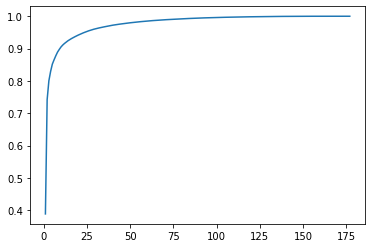

In [95]:
plt.plot(components, variances)

In [96]:
pca = PCA(n_components=len(X.columns))
pca.fit(X)
sum(pca.explained_variance_ratio_)

0.9999999999999999

In [97]:
X_pca = pca.transform(X)
X_pca

array([[-1.35793809e-01, -2.44095431e-01,  1.70073702e-01, ...,
         4.14120500e-04,  9.02230192e-04, -8.94081556e-04],
       [-1.99960680e-01, -2.44133668e-01,  1.67221878e-01, ...,
         7.56802688e-04,  2.14393083e-04, -4.46683616e-04],
       [-1.92540629e-01, -2.48545393e-01,  9.99869563e-02, ...,
         1.51206429e-04,  3.12492946e-04,  1.15117125e-03],
       ...,
       [-1.95538404e-01, -2.37282124e-01,  9.94428247e-02, ...,
        -8.61871688e-04,  2.81636431e-04, -1.12503034e-03],
       [ 2.66711646e-01, -2.47130940e-01, -2.29900283e-01, ...,
        -8.13395150e-04,  3.46257782e-04,  8.33134288e-04],
       [-1.96958728e-01, -2.33355655e-01,  5.96588534e-02, ...,
        -1.48560436e-04,  5.93106793e-04, -4.16254951e-04]])

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=5)

In [ ]:
rfc = RandomForestClassifier(random_state=0, n_estimators=10, min_samples_leaf=20)
rfc.fit(X_train,y_train)

In [ ]:
print("Accuracy for random forest classification: ")
print("Train data accuracy:",rfc.score(X_train, y_train))
print("Test data accuracy:",rfc.score(X_test, y_test))

In [99]:
classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(20, activation='relu', kernel_initializer='random_normal', input_dim=len(X_train[0])))
classifier.add(Dense(10, activation='relu', kernel_initializer='random_normal'))
classifier.add(Dense(10, activation='relu', kernel_initializer='random_normal'))
#Second  Hidden Layer
#classifier.add(Dense(20, activation='relu', kernel_initializer='random_normal'))
#classifier.add(Dense(20, activation='tanh', kernel_initializer='random_normal'))
#Output Layer
classifier.add(Dense(1, activation='sigmoid'))
classifier.compile(optimizer ='adam',loss='mean_squared_error', metrics =['accuracy'])

In [100]:
classifier.fit(X_train,y_train, batch_size=20, epochs=10)

Epoch 1/10
16062/16062 [==============================] - 13s 766us/step - loss: 0.0807 - accuracy: 0.8854
Epoch 2/10
16062/16062 [==============================] - 12s 775us/step - loss: 0.0769 - accuracy: 0.8904
Epoch 3/10
16062/16062 [==============================] - 12s 775us/step - loss: 0.0761 - accuracy: 0.8919
Epoch 4/10
16062/16062 [==============================] - 12s 774us/step - loss: 0.0755 - accuracy: 0.8927
Epoch 5/10
16062/16062 [==============================] - 12s 776us/step - loss: 0.0751 - accuracy: 0.8936
Epoch 6/10
16062/16062 [==============================] - 12s 765us/step - loss: 0.0748 - accuracy: 0.8942
Epoch 7/10
16062/16062 [==============================] - 12s 766us/step - loss: 0.0744 - accuracy: 0.8950
Epoch 8/10
16062/16062 [==============================] - 12s 765us/step - loss: 0.0742 - accuracy: 0.8955
Epoch 9/10
16062/16062 [==============================] - 12s 773us/step - loss: 0.0740 - accuracy: 0.8956
Epoch 10/10
16062/16062 [============

In [101]:
train_acc = classifier.evaluate(X_train, y_train, verbose=0)
print('Train loss:', train_acc[0]) 
print('Train accuracy:', train_acc[1])
test_acc = classifier.evaluate(X_test, y_test, verbose=0)
print('Test loss:', test_acc[0]) 
print('Test accuracy:', test_acc[1])

Train loss: 0.07312195003032684
Train accuracy: 0.8971077799797058
Test loss: 0.07601320743560791
Test accuracy: 0.8916062712669373


In [106]:
pred = list()
pred_unique = list(set(pred))
pred_count = list()
for p in pred:
    pred_count.append(pred.count(p))

In [110]:
pred = classifier.predict(X_test)
predictions = (pred > 0.5)*1
predictions.T[0]


4303/4303 [==============================] - 2s 567us/step


array([0, 0, 0, ..., 0, 1, 0])

<BarContainer object of 2 artists>

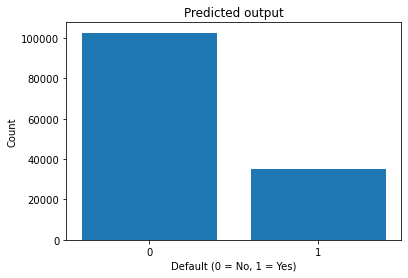

In [113]:
unique, counts = np.unique(predictions.T[0], return_counts=True)
plt.title("Predicted output")
plt.xlabel("Default (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.xticks([0,1])
plt.bar(unique, counts)

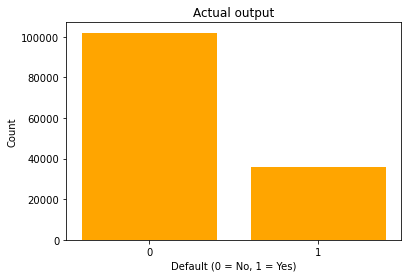

In [125]:
plt.title("Actual output")
plt.xlabel("Default (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.xticks([0,1])
plt.bar(y_test.unique(), y_test.value_counts(), color="orange")
plt.show()

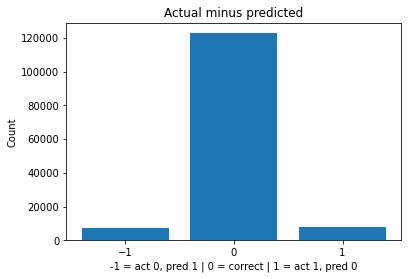

[-1.  0.  1.]
[  7140 122751   7783]


In [137]:
pred_error = y_test.values - predictions.T[0]
pred_unique, pred_counts = np.unique(pred_error, return_counts=True)

plt.title("Actual minus predicted")
plt.xlabel("-1 = act 0, pred 1 | 0 = correct | 1 = act 1, pred 0")
plt.ylabel("Count")
plt.xticks([-1,0,1])
plt.bar(pred_unique, pred_counts)
plt.show()
print(pred_unique)
print(pred_counts)

In [141]:
print((pred_counts[0]/pred_counts.sum())*100)
print((pred_counts[1]/pred_counts.sum())*100)
print((pred_counts[2]/pred_counts.sum())*100)

5.18616441739181
89.16062582622718
5.653209756381016


# SVM

In [ ]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

rbf_feature = RBFSampler()
X_features = rbf_feature.fit_transform(X_train)

clf = make_pipeline(StandardScaler(),
                     LinearSVC(random_state=0, tol=1e-3, max_iter=10000))

clf.fit(X_features, y_train)

In [ ]:
clf.score(X_features, y_train)

In [ ]:
X__test = (rbf_feature.fit_transform(X_test))

clf.score(X__test, y_test)